Mô hình dữ liệu x theo dạng bậc 6

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mapFeature(x1, x2, degree=6):
    out = [np.ones(x1.shape[0])]
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((x1 ** (i - j)) * (x2 ** j))
    return np.stack(out, axis=1)

1. Chia dữ liệu ra thành 2 tập: training (70%) và validation (30%). Phải đảm bảo việc chia dữ liệu là ngẫu nhiên và tỷ lệ positive và negative cân bằng.

In [20]:
df = pd.read_csv('data5.txt', header=None)
df.columns = ['x1', 'x2', 'y']

X_raw = df[['x1', 'x2']].values
y = df['y'].values

X_mapped = mapFeature(X_raw[:, 0], X_raw[:, 1]) 

idx_pos = np.where(y == 1)[0]
idx_neg = np.where(y == 0)[0]

np.random.seed(42)
np.random.shuffle(idx_pos)
np.random.shuffle(idx_neg)

n_pos_train = int(0.7 * len(idx_pos))
n_neg_train = int(0.7 * len(idx_neg))

idx_train = np.concatenate([idx_pos[:n_pos_train], idx_neg[:n_neg_train]])
idx_val   = np.concatenate([idx_pos[n_pos_train:], idx_neg[n_neg_train:]])

np.random.shuffle(idx_train)
np.random.shuffle(idx_val)

X_train = X_mapped[idx_train]
y_train = y[idx_train]
X_val   = X_mapped[idx_val]
y_val   = y[idx_val]

print("Data training:", X_train.shape[0])
print("  Positive:", np.sum(y_train == 1))
print("  Negative:", np.sum(y_train == 0))

print("Data validation:", X_val.shape[0])
print("  Positive:", np.sum(y_val == 1))
print("  Negative:", np.sum(y_val == 0))

train_full = np.hstack((X_train, y_train.reshape(-1, 1)))
val_full   = np.hstack((X_val, y_val.reshape(-1, 1)))

np.savetxt('train_data.txt', train_full, delimiter='\t', fmt='%.6f')
np.savetxt('val_data.txt', val_full, delimiter='\t', fmt='%.6f')

Data training: 82
  Positive: 40
  Negative: 42
Data validation: 36
  Positive: 18
  Negative: 18


2. Viết chương trình cho phép học các tham số của mô hình phân loại phi tuyến trên có sử dụng regularization L2 và L1.

In [21]:
train_data = np.loadtxt('train_data.txt', delimiter='\t')
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(theta, X, y, lambd=0.0, regularization='l2'):
    m = len(y)
    h = sigmoid(X @ theta)
    epsilon = 1e-8  # log(0)

    cost = -np.mean(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))

    # skip theta[0]
    if regularization == 'l2':
        reg = (lambd / (2 * m)) * np.sum(theta[1:] ** 2)
    elif regularization == 'l1':
        reg = (lambd / m) * np.sum(np.abs(theta[1:]))
    else:
        reg = 0

    return cost + reg

def compute_gradient(theta, X, y, lambd=0.0, regularization='l2'):
    m = len(y)
    h = sigmoid(X @ theta)
    error = h - y
    grad = (1 / m) * (X.T @ error)

    if regularization == 'l2':
        grad[1:] += (lambd / m) * theta[1:]
    elif regularization == 'l1':
        grad[1:] += (lambd / m) * np.sign(theta[1:])

    return grad

def train_logistic_regression(X, y, lambd=0.0, regularization='l2', alpha=0.1, num_iters=1000):
    theta = np.zeros(X.shape[1])
    J_history = []

    for i in range(num_iters):
        grad = compute_gradient(theta, X, y, lambd, regularization)
        theta -= alpha * grad
        J = compute_cost(theta, X, y, lambd, regularization)
        J_history.append(J)
        
        if i % 100 == 0:
            print(f"Iteration {i}: J = {J:.6f}")

    return theta, J_history

theta_l2, J_l2_history = train_logistic_regression(
    X_train, y_train, lambd=0.1, regularization='l2', alpha=0.5, num_iters=1000
)

theta_l1, J_l1_history = train_logistic_regression(
    X_train, y_train, lambd=0.1, regularization='l1', alpha=0.1, num_iters=1000
)

print("J (L2):", J_l2_history[-1])
print("J (L1):", J_l1_history[-1])

Iteration 0: J = 0.687128
Iteration 100: J = 0.500398
Iteration 200: J = 0.445871
Iteration 300: J = 0.421463
Iteration 400: J = 0.408490
Iteration 500: J = 0.400927
Iteration 600: J = 0.396254
Iteration 700: J = 0.393245
Iteration 800: J = 0.391247
Iteration 900: J = 0.389885
Iteration 0: J = 0.691952
Iteration 100: J = 0.627399
Iteration 200: J = 0.585877
Iteration 300: J = 0.554885
Iteration 400: J = 0.530891
Iteration 500: J = 0.511805
Iteration 600: J = 0.496278
Iteration 700: J = 0.483400
Iteration 800: J = 0.472546
Iteration 900: J = 0.463269
J (L2): 0.38894432999861533
J (L1): 0.4553235189228132


3. Tính J ở mỗi vòng lặp cho cả hai tập, chọn điểm dừng phù hợp.

Iter 0: J_train = 0.68713, J_val = 0.68819
Iter 100: J_train = 0.50040, J_val = 0.56826
Iter 200: J_train = 0.44587, J_val = 0.55260
Early stopping at iteration 251 (val loss converged)


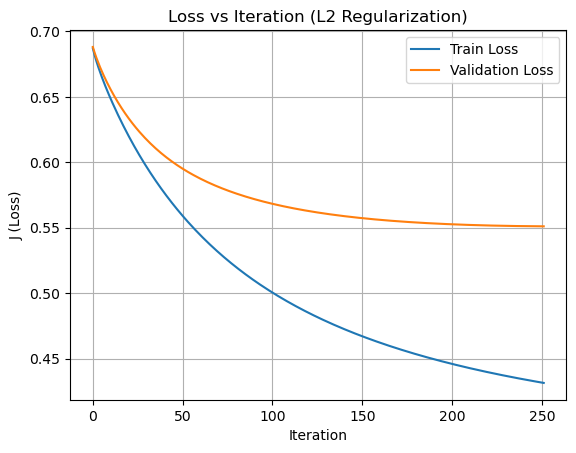

In [22]:
train_data = np.loadtxt('train_data.txt', delimiter='\t')
X_train = train_data[:, :-1]
y_train = train_data[:, -1]

val_data = np.loadtxt('val_data.txt', delimiter='\t')
X_val = val_data[:, :-1]
y_val = val_data[:, -1]

def train_with_validation(X_train, y_train, X_val, y_val, lambd=0.1, regularization='l2',
                          alpha=0.1, num_iters=1000, tol=1e-5):
    theta = np.zeros(X_train.shape[1])
    J_train_hist = []
    J_val_hist = []
    
    for i in range(num_iters):
        grad = compute_gradient(theta, X_train, y_train, lambd, regularization)
        theta -= alpha * grad

        # Tính J cho train và val
        J_train = compute_cost(theta, X_train, y_train, lambd, regularization)
        J_val   = compute_cost(theta, X_val, y_val, lambd, regularization)
        
        J_train_hist.append(J_train)
        J_val_hist.append(J_val)

        # In thông tin mỗi 100 vòng
        if i % 100 == 0:
            print(f"Iter {i}: J_train = {J_train:.5f}, J_val = {J_val:.5f}")
        
        # Kiểm tra hội tụ sớm
        if i > 10 and abs(J_val_hist[-2] - J_val_hist[-1]) < tol:
            print(f"Early stopping at iteration {i} (val loss converged)")
            break

    return theta, J_train_hist, J_val_hist

theta_l2, J_train_l2, J_val_l2 = train_with_validation(
    X_train, y_train, X_val, y_val,
    lambd=0.1, regularization='l2',
    alpha=0.5, num_iters=1000
)

plt.plot(J_train_l2, label='Train Loss')
plt.plot(J_val_l2, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('J (Loss)')
plt.title('Loss vs Iteration (L2 Regularization)')
plt.legend()
plt.grid(True)
plt.show()
